 <h1 style="font-size:2em;color:#2467C0">Phase 2 Urban World Prediction Challenge</h1>

Import libraries

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from datetime import timedelta

Loading dataset

In [3]:
base_dir = os.path.abspath('../data') 
initial_data_file_1 = base_dir + r'/RunDataTable.tsv'
initial_data_file_2 = base_dir + r'/Urban World Predict Challenge Data/RunDataTable.tsv'
rr_0260_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0260-RunDataTable.tsv'
rr_0310_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0310-RunDataTable.tsv'
rr_0320_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0320-RunDataTable.tsv'
rr_0330_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0330-RunDataTable.tsv'
rr_0340_qualitative_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0340-QualitativeDataTable.tsv'
rr_0340_relationship_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0340-RelationshipDataTable.tsv'
rr_0340_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0340-RunDataTable.tsv'
rr_0370_qualitative_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0370-QualitativeDataTable.tsv'
rr_0370_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0370-RunDataTable.tsv'
rr_0380_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0380-RunDataTable.tsv'
rr_0390_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0390-RunDataTable.tsv'
idp_sup_data_file = base_dir + r'/Urban World Predict Challenge Data/IDP_SUP_RunDataTable.tsv'

In [4]:
initial_data_1 = pd.read_table(initial_data_file_1,parse_dates=True)
initial_data_1['VariableName'].unique()
# initial_data_1[initial_data_1['VariableName']=='OngoingMeetingId']

array(['CurrentVisitor', 'OngoingMeetingId', 'Participant', 'Checkin',
       'Checkout', 'SiteType', 'SiteLocation', 'BuildingId', 'ApproxAge',
       'HomeLocation', 'WorkLocation', 'IncomePerHour'], dtype=object)

In [5]:
initial_data_2 = pd.read_csv(initial_data_file_2,delimiter='\t',encoding='utf-8', index_col=False)
initial_data_2['VariableName'].unique()

/home/workstation/software/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['CurrentVisitor', 'OngoingMeetingId', 'Participant', 'Enter',
       'Leave', 'Checkin', 'Checkout'], dtype=object)

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">
Predict Test Question 1a
</p> 

<p style="font-family: Arial; font-size:1.25em;color:#2462C0; font-style:bold">
Data preprocessing</p>

The function below returns a dataset of total number of visit per day for a specific site.

In [5]:
def get_visit_data(data, site_id):
    visit_data = data[data['VariableName']=='CurrentVisitor']
    visit_data = visit_data[visit_data['EntityIdx']==site_id]
    visit_data = pd.DataFrame(visit_data.groupby('Timestep')['Value'].apply(' '.join))
    visit_data['Prev_value'] = visit_data.shift(1)['Value']
    if visit_data.empty == True:
        return pd.DataFrame()
    def func(x):
        if pd.isna(x['Value'])==False:
            a = set(x['Value'].split())
        else:
            a=set()
    
        if pd.isna(x['Prev_value'])==False:
            b = set(x['Prev_value'].split())
        else:
            b = set()
        return len(a.difference(b))
 
    visit_data[site_id]=visit_data.apply(lambda x: func(x),  axis=1)
    visit_data.index = pd.to_datetime(visit_data.index)
    visit_data=visit_data.resample('D').sum()
    return visit_data

Function to normalize data.

In [6]:
def normalize(data, train_split):
    mean = data[:TRAIN_SPLIT].mean()
    std = data[:TRAIN_SPLIT].std()
    data = (data-mean)/std
    return data


In [7]:
    
PRED_SITES=['Site-2629','Site-5298','Site-5299','Site-10648', 'Site-7976']

CLOSED_SITES =['Site-2627', 'Site-2628', 'Site-2630', 'Site-2634', 'Site-2636',
                'Site-2637', 'Site-2638', 'Site-5297', 'Site-5300', 'Site-5308',
                'Site-5309', 'Site-5311', 'Site-7968', 'Site-7969', 'Site-7979',
                'Site-10640', 'Site-10649', 'Site-10650', 'Site-10651', 'Site-10652']

# site_2629_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-2629')
# site_2629_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-2629')
# site_2629_meeting_data =  pd.concat([site_2629_meeting_data_1, site_2629_meeting_data_2])


sites_visit_data_scene_1={}
for site in PRED_SITES:
    data_1 = get_visit_data(initial_data_1, site)
    data_2 = get_visit_data(initial_data_2, site)
    data=pd.concat([data_1, data_2])
    sites_visit_data_scene_1[site]=data

    
sites_visit_data_scene_1[PRED_SITES[0]]


,Site-2629
Timestep,
2019-08-01,294
2019-08-02,268
2019-08-03,545
2019-08-04,497
2019-08-05,205
...,...
2022-07-09,49
2022-07-10,0
2022-07-11,69


In [8]:
close_sites_visit_data = {}
for close_site in CLOSED_SITES:
        close_site_visit_data_1 = get_visit_data(initial_data_1, close_site)
        close_site_visit_data_2 = get_visit_data(initial_data_2, close_site)
        close_site_visit_data = pd.concat([close_site_visit_data_1, close_site_visit_data_2])
        close_sites_visit_data[close_site] = close_site_visit_data
#         print(close_site_visit_data)

def concat_site_visit_data(site, close_sites_visit_data):
    site_data_1 = get_visit_data(initial_data_1, site)
    site_data_2 = get_visit_data(initial_data_2, site)
    site_data =  pd.concat([site_data_1, site_data_2])

    ret = site_data
    for close_site in CLOSED_SITES:
        close_site_visit_data = close_sites_visit_data[close_site]
#         print(close_site_visit_data)
        ret = pd.concat([ret,close_site_visit_data], axis=1, sort=False)
    return ret

sites_visit_data_scene_2={}
for site in PRED_SITES:
    concat_site_data=concat_site_visit_data(site,close_sites_visit_data)
    sites_visit_data_scene_2[site]=concat_site_data
    sites_visit_data_scene_2[site]=sites_visit_data_scene_2[site].fillna(0)

In [18]:
sites_visit_data_scene_1[PRED_SITES[0]]

,Site-2629
Timestep,
2019-08-01,294
2019-08-02,268
2019-08-03,545
2019-08-04,497
2019-08-05,205
...,...
2022-07-09,49
2022-07-10,0
2022-07-11,69


Now we have to divide data into features and labels. For time series data features are previous obeserved values and label is the value to be predicted. Here, the number of features is called window size and a slice of the time series of length equal to window size is called a window. The following function creates a windowed dataset from the given time series. Here target_size is the number of future predicted values.

In [15]:
def windowed_data(dataframe, window_size, target_size, batch_size,shuffle=True, repeat = True):
    dataset = tf.data.Dataset.from_tensor_slices(dataframe)
    dataset = dataset.window(window_size+target_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+target_size))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda window: (window[:-target_size],window[-target_size:]))
    dataset = dataset.batch(batch_size)
    if repeat:
        dataset = dataset.repeat()
    return dataset

We have to split the data into train and validation set. We set training data size to 100. the rest of the data will be used for validation. Window size is set to 8 and future target size is set to 5.

In [19]:
TRAIN_SPLIT = 100
BATCH_SIZE = 100
window_size = 7
target_size = 5
REPEAT = False

In [20]:
# site_2629_meeting_values = site_2629_meeting_data.values
# site_2629_meeting_values.shape
sites_visit_train_dataset_scene_1={}
sites_visit_validation_dataset_scene_1={}
for site_key in sites_visit_data_scene_1:
    data=sites_visit_data_scene_1[site_key]
    sites_visit_train_dataset_scene_1[site_key]=windowed_data(data.values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE, repeat= REPEAT)
    sites_visit_validation_dataset_scene_1[site_key]=windowed_data(data.values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE,repeat = REPEAT)


In [21]:
# site_2629_train_dataset = windowed_data(site_2629_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
# site_2629_validation_dataset = windowed_data(site_2629_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)

for x, y in sites_visit_train_dataset_scene_1['Site-2629'].take(1):
    print('x=',x.shape, 'y=',y.shape)
#     print('x=',x.numpy(), 'y=',y.numpy())

x= (89, 7, 1) y= (89, 5, 1)


For scenerio 2 we use the close site visit information as features to see the influence of closed sites on selected site visit.

In [22]:
def multivariate_windowed_data(dataframe, window_size, target_size, batch_size,shuffle=True, repeat = True):
    dataset = tf.data.Dataset.from_tensor_slices(dataframe)
    dataset = dataset.window(window_size+target_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+target_size))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda window: (window[:-target_size],window[-target_size:,0:1]))
    dataset = dataset.batch(batch_size)
    if repeat:
        dataset = dataset.repeat()
    return dataset
    

In [108]:
# site_2629_meeting_values = site_2629_meeting_data.values
# site_2629_meeting_values.shape
sites_visit_train_dataset_scene_2={}
sites_visit_validation_dataset_scene_2={}
for site_key in sites_visit_data_scene_2:
    data=sites_visit_data_scene_2[site_key]
    sites_visit_train_dataset_scene_2[site_key]=multivariate_windowed_data(data.values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
    sites_visit_validation_dataset_scene_2[site_key]=multivariate_windowed_data(data.values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)


In [109]:
# site_2629_train_dataset = windowed_data(site_2629_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
# site_2629_validation_dataset = windowed_data(site_2629_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)

for x, y in sites_visit_train_dataset_scene_2['Site-2629'].take(1):
    print('x=',x.shape, 'y=',y.shape)
#     print('x=',x.numpy(), 'y=',y.numpy())

x= (50, 7, 21) y= (50, 5, 1)


<p style="font-family: Arial; font-size:1.25em;color:#2462C0; font-style:bold">
Building and Training Model for Scenerio 1</p>

The below function plots loss history of the model.

In [15]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

This function plot forcast for scene 1. 

In [18]:
def plot_forecast_scene_1(model, data, site, window_size,target_size):
    forecast = []
    values=data.values
    for time in range(0, len(values) - window_size,target_size):
        pred = model.predict(values[time:time + window_size][np.newaxis].astype(np.float32))
        pred = pred.reshape(target_size)
        forecast.append(pred)
    forecast = np.array(forecast).reshape(-1)
    
    res = pd.concat([data[window_size:].reset_index()[site], pd.DataFrame(forecast)], axis =1)
    res.plot()

The function below returns prediction for 30 days from P-day.


In [18]:
def p_day_forecast_scene_1(model, data, site, window_size, target_size):
    last_date=data.index[-1]
    p_day = datetime(2022, 7, 15)
    delta = p_day-last_date
    x = data.values[-window_size:]
    for time in range (0, 30 + delta.days,target_size):
        pred = model.predict(x[np.newaxis, time:time+window_size].astype(np.float32)) 
        pred = pred.reshape((target_size,1))
        pred=np.rint(pred) 
        x = np.concatenate([x, pred], axis=0)
    
    index=pd.date_range(data.index[-window_size], periods=x.shape[0])
    x=pd.DataFrame(x,index=index, columns=['Value'])
    x.index.rename('Timestep',inplace=True)
    x = x[p_day:p_day+timedelta(30)]
    x['Scenario']='Scenario 1'
    x['Site'] = site
    x = x.reset_index()
    x=x[['Scenario', 'Site', 'Timestep', 'Value']]
    return x

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8086747d10>,
      dtype=object)

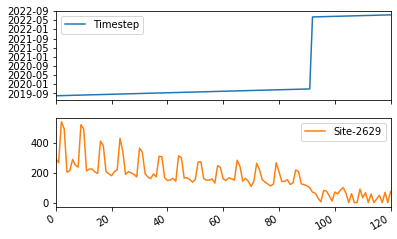

In [49]:
sites_visit_data_scene_1['Site-2629'].reset_index().plot(subplots=True)

In [41]:
def train_model(model, train_dataset, validation_dataset, epochs, steps_per_epoch, validation_steps):
    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
#     history = model.fit(train_dataset, epochs=epochs,validation_data=validation_dataset,
#                         steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
    history = model.fit(train_dataset, epochs=epochs,validation_data=validation_dataset)
                        
    return history

In [69]:
site='Site-2629'
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(128,
                     dropout=0.2,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, 1)))
model.add(tf.keras.layers.GRU(128,
                              return_sequences=True,
                     dropout=0.2,
                     recurrent_dropout=0.5
                     ))
model.add(tf.keras.layers.GRU(128,
                     dropout=0.2,
                     recurrent_dropout=0.5,
                              activation='relu'
                     ))
model.add(tf.keras.layers.Dense(target_size, activation = 'relu'))
history = train_model( model , sites_visit_train_dataset_scene_1[site], 
                             sites_visit_validation_dataset_scene_1[site], 1000,100,100)

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 192.2591 - val_loss: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 64ms/step - loss: 189.0378 - val_loss: 33.0837
Epoch 3/1000
1/1 [==============================] - 0s 68ms/step - loss: 180.0991 - val_loss: 32.6043
Epoch 4/1000
1/1 [==============================] - 0s 69ms/step - loss: 167.0389 - val_loss: 31.7605
Epoch 5/1000
1/1 [==============================] - 0s 69ms/step - loss: 145.2293 - val_loss: 30.2824
Epoch 6/1000
1/1 [==============================] - 0s 72ms/step - loss: 111.9422 - val_loss: 28.2040
Epoch 7/1000
1/1 [==============================] - 0s 70ms/step - loss: 91.1315 - val_loss: 28.6543
Epoch 8/1000
1/1 [==============================] - 0s 70ms/step - loss: 96.3726 - val_loss: 28.3040
Epoch 9/1000
1/1 [==============================] - 0s 74ms/step - loss: 100.7512 - val_loss: 28.7832
Epoch 10/1000
1/1 [==============================] - 0s 79ms/step - loss: 91.5620 -

Epoch 82/1000
1/1 [==============================] - 0s 79ms/step - loss: 67.1530 - val_loss: 29.7403
Epoch 83/1000
1/1 [==============================] - 0s 79ms/step - loss: 67.1116 - val_loss: 28.7366
Epoch 84/1000
1/1 [==============================] - 0s 94ms/step - loss: 65.8206 - val_loss: 29.5645
Epoch 85/1000
1/1 [==============================] - 0s 95ms/step - loss: 62.5065 - val_loss: 29.1149
Epoch 86/1000
1/1 [==============================] - 0s 89ms/step - loss: 61.8652 - val_loss: 29.4790
Epoch 87/1000
1/1 [==============================] - 0s 77ms/step - loss: 58.9004 - val_loss: 29.3313
Epoch 88/1000
1/1 [==============================] - 0s 70ms/step - loss: 62.5176 - val_loss: 29.5561
Epoch 89/1000
1/1 [==============================] - 0s 68ms/step - loss: 61.7878 - val_loss: 29.1921
Epoch 90/1000
1/1 [==============================] - 0s 67ms/step - loss: 61.4953 - val_loss: 29.6582
Epoch 91/1000
1/1 [==============================] - 0s 66ms/step - loss: 62.0769 

Epoch 162/1000
1/1 [==============================] - 0s 75ms/step - loss: 59.9662 - val_loss: 29.4197
Epoch 163/1000
1/1 [==============================] - 0s 75ms/step - loss: 61.9455 - val_loss: 30.1955
Epoch 164/1000
1/1 [==============================] - 0s 72ms/step - loss: 64.8631 - val_loss: 29.4539
Epoch 165/1000
1/1 [==============================] - 0s 69ms/step - loss: 64.9392 - val_loss: 30.4367
Epoch 166/1000
1/1 [==============================] - 0s 70ms/step - loss: 66.3749 - val_loss: 29.4706
Epoch 167/1000
1/1 [==============================] - 0s 71ms/step - loss: 64.1422 - val_loss: 30.2076
Epoch 168/1000
1/1 [==============================] - 0s 65ms/step - loss: 60.2820 - val_loss: 29.5648
Epoch 169/1000
1/1 [==============================] - 0s 69ms/step - loss: 61.7957 - val_loss: 30.0766
Epoch 170/1000
1/1 [==============================] - 0s 69ms/step - loss: 61.4890 - val_loss: 29.5856
Epoch 171/1000
1/1 [==============================] - 0s 67ms/step - loss

Epoch 242/1000
1/1 [==============================] - 0s 68ms/step - loss: 57.3189 - val_loss: 30.1755
Epoch 243/1000
1/1 [==============================] - 0s 75ms/step - loss: 57.1161 - val_loss: 30.1137
Epoch 244/1000
1/1 [==============================] - 0s 74ms/step - loss: 56.6121 - val_loss: 30.6640
Epoch 245/1000
1/1 [==============================] - 0s 78ms/step - loss: 60.2635 - val_loss: 29.8105
Epoch 246/1000
1/1 [==============================] - 0s 75ms/step - loss: 64.4260 - val_loss: 30.7273
Epoch 247/1000
1/1 [==============================] - 0s 77ms/step - loss: 63.0698 - val_loss: 29.8168
Epoch 248/1000
1/1 [==============================] - 0s 80ms/step - loss: 60.0910 - val_loss: 30.4513
Epoch 249/1000
1/1 [==============================] - 0s 76ms/step - loss: 55.8941 - val_loss: 30.2156
Epoch 250/1000
1/1 [==============================] - 0s 74ms/step - loss: 57.5883 - val_loss: 30.4379
Epoch 251/1000
1/1 [==============================] - 0s 70ms/step - loss

Epoch 322/1000
1/1 [==============================] - 0s 76ms/step - loss: 56.8669 - val_loss: 29.9370
Epoch 323/1000
1/1 [==============================] - 0s 76ms/step - loss: 58.6842 - val_loss: 30.3101
Epoch 324/1000
1/1 [==============================] - 0s 71ms/step - loss: 56.6840 - val_loss: 30.0634
Epoch 325/1000
1/1 [==============================] - 0s 74ms/step - loss: 57.2167 - val_loss: 30.1295
Epoch 326/1000
1/1 [==============================] - 0s 73ms/step - loss: 53.5063 - val_loss: 30.2307
Epoch 327/1000
1/1 [==============================] - 0s 70ms/step - loss: 54.1363 - val_loss: 30.0332
Epoch 328/1000
1/1 [==============================] - 0s 75ms/step - loss: 56.9283 - val_loss: 30.6075
Epoch 329/1000
1/1 [==============================] - 0s 78ms/step - loss: 61.0052 - val_loss: 29.6779
Epoch 330/1000
1/1 [==============================] - 0s 78ms/step - loss: 63.8942 - val_loss: 30.6470
Epoch 331/1000
1/1 [==============================] - 0s 72ms/step - loss

Epoch 402/1000
1/1 [==============================] - 0s 75ms/step - loss: 56.3372 - val_loss: 30.4227
Epoch 403/1000
1/1 [==============================] - 0s 75ms/step - loss: 56.6937 - val_loss: 29.7340
Epoch 404/1000
1/1 [==============================] - 0s 75ms/step - loss: 57.9008 - val_loss: 30.3214
Epoch 405/1000
1/1 [==============================] - 0s 84ms/step - loss: 56.7822 - val_loss: 29.8283
Epoch 406/1000
1/1 [==============================] - 0s 80ms/step - loss: 55.4577 - val_loss: 30.2236
Epoch 407/1000
1/1 [==============================] - 0s 82ms/step - loss: 56.9007 - val_loss: 29.8905
Epoch 408/1000
1/1 [==============================] - 0s 73ms/step - loss: 56.0865 - val_loss: 30.1133
Epoch 409/1000
1/1 [==============================] - 0s 72ms/step - loss: 54.1101 - val_loss: 30.0687
Epoch 410/1000
1/1 [==============================] - 0s 67ms/step - loss: 53.4374 - val_loss: 30.1585
Epoch 411/1000
1/1 [==============================] - 0s 72ms/step - loss

Epoch 482/1000
1/1 [==============================] - 0s 78ms/step - loss: 57.9562 - val_loss: 29.6520
Epoch 483/1000
1/1 [==============================] - 0s 72ms/step - loss: 54.5031 - val_loss: 29.9859
Epoch 484/1000
1/1 [==============================] - 0s 72ms/step - loss: 56.3305 - val_loss: 29.6512
Epoch 485/1000
1/1 [==============================] - 0s 69ms/step - loss: 53.1521 - val_loss: 30.1376
Epoch 486/1000
1/1 [==============================] - 0s 70ms/step - loss: 54.0803 - val_loss: 29.6649
Epoch 487/1000
1/1 [==============================] - 0s 72ms/step - loss: 53.1564 - val_loss: 30.1027
Epoch 488/1000
1/1 [==============================] - 0s 74ms/step - loss: 53.6591 - val_loss: 29.6696
Epoch 489/1000
1/1 [==============================] - 0s 74ms/step - loss: 55.3439 - val_loss: 30.0628
Epoch 490/1000
1/1 [==============================] - 0s 74ms/step - loss: 53.3646 - val_loss: 29.5076
Epoch 491/1000
1/1 [==============================] - 0s 74ms/step - loss

Epoch 562/1000
1/1 [==============================] - 0s 79ms/step - loss: 51.8985 - val_loss: 29.3896
Epoch 563/1000
1/1 [==============================] - 0s 77ms/step - loss: 58.3465 - val_loss: 29.9438
Epoch 564/1000
1/1 [==============================] - 0s 75ms/step - loss: 57.1310 - val_loss: 29.4018
Epoch 565/1000
1/1 [==============================] - 0s 82ms/step - loss: 54.3064 - val_loss: 29.6717
Epoch 566/1000
1/1 [==============================] - 0s 86ms/step - loss: 53.7080 - val_loss: 29.4714
Epoch 567/1000
1/1 [==============================] - 0s 80ms/step - loss: 51.6879 - val_loss: 29.7507
Epoch 568/1000
1/1 [==============================] - 0s 78ms/step - loss: 54.0105 - val_loss: 29.5622
Epoch 569/1000
1/1 [==============================] - 0s 79ms/step - loss: 52.5385 - val_loss: 29.7816
Epoch 570/1000
1/1 [==============================] - 0s 84ms/step - loss: 52.4153 - val_loss: 29.4806
Epoch 571/1000
1/1 [==============================] - 0s 88ms/step - loss

Epoch 642/1000
1/1 [==============================] - 0s 63ms/step - loss: 57.9196 - val_loss: 29.6548
Epoch 643/1000
1/1 [==============================] - 0s 63ms/step - loss: 55.9827 - val_loss: 29.8489
Epoch 644/1000
1/1 [==============================] - 0s 63ms/step - loss: 51.1434 - val_loss: 29.5134
Epoch 645/1000
1/1 [==============================] - 0s 63ms/step - loss: 55.2974 - val_loss: 29.9584
Epoch 646/1000
1/1 [==============================] - 0s 64ms/step - loss: 56.2765 - val_loss: 29.6146
Epoch 647/1000
1/1 [==============================] - 0s 64ms/step - loss: 50.0594 - val_loss: 29.7538
Epoch 648/1000
1/1 [==============================] - 0s 66ms/step - loss: 48.7999 - val_loss: 29.7294
Epoch 649/1000
1/1 [==============================] - 0s 69ms/step - loss: 50.9887 - val_loss: 29.7261
Epoch 650/1000
1/1 [==============================] - 0s 67ms/step - loss: 47.3914 - val_loss: 29.7349
Epoch 651/1000
1/1 [==============================] - 0s 68ms/step - loss

Epoch 722/1000
1/1 [==============================] - 0s 66ms/step - loss: 49.8908 - val_loss: 29.5485
Epoch 723/1000
1/1 [==============================] - 0s 68ms/step - loss: 49.2250 - val_loss: 29.8671
Epoch 724/1000
1/1 [==============================] - 0s 64ms/step - loss: 55.6303 - val_loss: 29.6044
Epoch 725/1000
1/1 [==============================] - 0s 63ms/step - loss: 50.7558 - val_loss: 29.8452
Epoch 726/1000
1/1 [==============================] - 0s 66ms/step - loss: 47.2342 - val_loss: 29.6542
Epoch 727/1000
1/1 [==============================] - 0s 69ms/step - loss: 50.7926 - val_loss: 29.9120
Epoch 728/1000
1/1 [==============================] - 0s 63ms/step - loss: 51.8773 - val_loss: 29.5178
Epoch 729/1000
1/1 [==============================] - 0s 63ms/step - loss: 53.4762 - val_loss: 29.9027
Epoch 730/1000
1/1 [==============================] - 0s 64ms/step - loss: 51.5200 - val_loss: 29.5725
Epoch 731/1000
1/1 [==============================] - 0s 65ms/step - loss

Epoch 802/1000
1/1 [==============================] - 0s 65ms/step - loss: 45.3773 - val_loss: 29.5115
Epoch 803/1000
1/1 [==============================] - 0s 67ms/step - loss: 49.6386 - val_loss: 29.6476
Epoch 804/1000
1/1 [==============================] - 0s 68ms/step - loss: 45.8630 - val_loss: 29.5483
Epoch 805/1000
1/1 [==============================] - 0s 63ms/step - loss: 47.3782 - val_loss: 29.6373
Epoch 806/1000
1/1 [==============================] - 0s 62ms/step - loss: 49.6556 - val_loss: 29.5475
Epoch 807/1000
1/1 [==============================] - 0s 64ms/step - loss: 49.4544 - val_loss: 29.8038
Epoch 808/1000
1/1 [==============================] - 0s 64ms/step - loss: 50.8186 - val_loss: 29.3905
Epoch 809/1000
1/1 [==============================] - 0s 64ms/step - loss: 57.0848 - val_loss: 29.9563
Epoch 810/1000
1/1 [==============================] - 0s 65ms/step - loss: 57.2771 - val_loss: 29.5122
Epoch 811/1000
1/1 [==============================] - 0s 63ms/step - loss

Epoch 882/1000
1/1 [==============================] - 0s 65ms/step - loss: 47.1726 - val_loss: 29.9568
Epoch 883/1000
1/1 [==============================] - 0s 66ms/step - loss: 53.7934 - val_loss: 29.5355
Epoch 884/1000
1/1 [==============================] - 0s 67ms/step - loss: 49.4403 - val_loss: 29.8587
Epoch 885/1000
1/1 [==============================] - 0s 62ms/step - loss: 49.1524 - val_loss: 29.6866
Epoch 886/1000
1/1 [==============================] - 0s 63ms/step - loss: 47.0397 - val_loss: 29.8157
Epoch 887/1000
1/1 [==============================] - 0s 64ms/step - loss: 47.7507 - val_loss: 29.6585
Epoch 888/1000
1/1 [==============================] - 0s 64ms/step - loss: 48.2761 - val_loss: 29.7925
Epoch 889/1000
1/1 [==============================] - 0s 81ms/step - loss: 46.2646 - val_loss: 29.6261
Epoch 890/1000
1/1 [==============================] - 0s 91ms/step - loss: 48.2405 - val_loss: 29.7076
Epoch 891/1000
1/1 [==============================] - 0s 92ms/step - loss

Epoch 962/1000
1/1 [==============================] - 0s 67ms/step - loss: 45.8088 - val_loss: 29.9912
Epoch 963/1000
1/1 [==============================] - 0s 69ms/step - loss: 51.0491 - val_loss: 29.7168
Epoch 964/1000
1/1 [==============================] - 0s 65ms/step - loss: 43.2159 - val_loss: 29.8839
Epoch 965/1000
1/1 [==============================] - 0s 68ms/step - loss: 46.2851 - val_loss: 29.8415
Epoch 966/1000
1/1 [==============================] - 0s 67ms/step - loss: 47.8226 - val_loss: 29.8039
Epoch 967/1000
1/1 [==============================] - 0s 63ms/step - loss: 45.9135 - val_loss: 29.8240
Epoch 968/1000
1/1 [==============================] - 0s 64ms/step - loss: 44.0716 - val_loss: 29.7013
Epoch 969/1000
1/1 [==============================] - 0s 79ms/step - loss: 47.6230 - val_loss: 29.7830
Epoch 970/1000
1/1 [==============================] - 0s 92ms/step - loss: 45.7636 - val_loss: 29.7207
Epoch 971/1000
1/1 [==============================] - 0s 100ms/step - los

In [66]:
model.predict(sites_visit_data_scene_1['Site-2629'].values[0:7][np.newaxis].astype(np.float32))


array([[ 8.477048, 12.813763, 13.862657, 12.34868 , 10.390762]],
      dtype=float32)

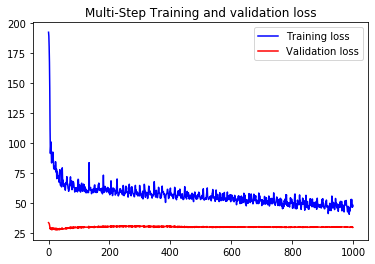

[19.536495   15.878883   16.524164   22.729034   24.21974    16.693787
 14.278098   16.625654   22.922342   22.461466   23.00562    15.035796
 18.367544   24.53586    24.005531   19.015665   18.781706   14.177188
 17.938812   22.049696   16.496944   12.97125    12.936538   19.528454
 21.635492   17.258959   13.535766   18.744019   24.720514   22.80416
 21.558985   15.53483    11.910942   16.854723   20.102617   15.887615
 12.521755   10.174764   14.184404   17.480427   16.684603   12.73501
 13.963461   20.900717   22.212      17.443195   11.4391575  10.683403
 13.655486   15.543604   14.04244    12.114375    9.106168   10.7260895
 14.1232815  16.212465   12.634085   10.993651   16.067747   19.09154
 16.171192   11.968613   13.71817    18.708494   19.690775   12.935357
  9.135384    7.4182615   9.537248   11.700428   12.0872755   9.624594
  8.2108755  10.352456   13.0539255  11.476306    8.653168    8.353982
 10.368723   12.7300415  10.36823     7.886006    7.5392127   9.5321865
 10.967

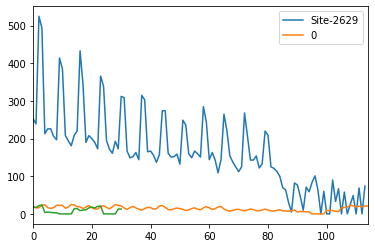

In [70]:
site='Site-2629'
plot_train_history(history, 'Multi-Step Training and validation loss')
pred = p_day_forecast_scene_1(model,sites_visit_data_scene_1[site],site,window_size, target_size)
pred['Value'].plot()
pred.to_csv( base_dir + r'/prediction/'+site+'visit_forcast_1.csv',index=False)

In [ ]:
plot_train_history(history, 'Multi-Step Training and validation loss')

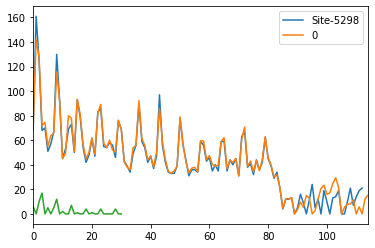

In [125]:
# for site in PRED_SITES:
plot_forecast_scene_2(model ,sites_meeting_data[site],site, window_size,target_size)
pred = p_day_forecast_scene_2(model,sites_meeting_data[site],site,window_size, target_size)
# print(pred)
pred['Value'].plot()


In [116]:
pred.to_csv( base_dir + r'/prediction/'+site+'_forcast_2.csv',index=False)

In [50]:
site_2629_forcast_1=p_day_forecast_scene_1(model_2629, site_2629_meeting_data,'Site_2629', window_size, target_size)
site_2629_forcast_1
site_2629_forcast_1.to_csv( base_dir + r'/prediction/site_2629_forcast_1.csv',index=False)

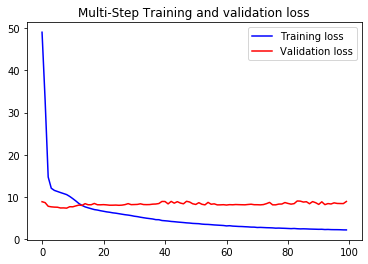

In [124]:
plot_train_history(history, 'Multi-Step Training and validation loss')

<p style="font-family: Arial; font-size:1.25em;color:#2462C0; font-style:bold">
Building and Training Model for Scenerio 2</p>

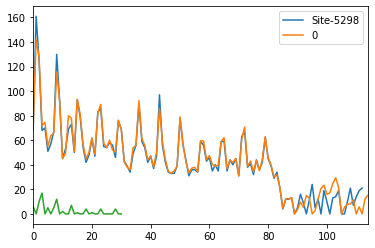

In [125]:
# for site in PRED_SITES:
plot_forecast_scene_2(model ,sites_meeting_data[site],site, window_size,target_size)
pred = p_day_forecast_scene_2(model,sites_meeting_data[site],site,window_size, target_size)
# print(pred)
pred['Value'].plot()


In [116]:

pred.to_csv( base_dir + r'/prediction/'+site+'_forcast_2.csv',index=False)

In [61]:
def p_day_forecast_scene_2(model, data, site, window_size, target_size):
    last_date=data.index[-1]
    p_day = datetime(2022, 7, 15)
    delta = p_day-last_date
    x = data.values[-window_size:]
    for time in range (0, 30 + delta.days,target_size):
        pred = model.predict(x[np.newaxis, time:time+window_size].astype(np.float32)) 
        pred = pred.reshape((target_size,1))
        pred=np.rint(pred)
        y = np.empty((target_size, x.shape[1]))
        y[:,0:1]=pred
        y[:,1:]=0
        x = np.concatenate([x, y], axis=0)
    
    index=pd.date_range(data.index[-window_size], periods=x.shape[0])
    x=pd.DataFrame(x[:,0],index=index,columns=['Value'])
    x.index.rename('Timestep',inplace=True)
    x = x[p_day:p_day+timedelta(30)]
    x['Scenario']='Scenario 2'
    x['Site'] = site
    x = x.reset_index()
    x=x[['Scenario','Site','Timestep','Value']]
    return x


# p_day_forecast_scene_2(model,sites_meeting_data['Site-2629'],'Site-2629',window_size, target_size)

In [69]:
def plot_forecast_scene_2(model, data, site, window_size,target_size):
    forecast = []
    values=data.values
    for time in range(0, len(values) - window_size,target_size):
        x=values[time:time + window_size][np.newaxis].astype(np.float32)
        pred = model.predict(x)
        pred = pred.reshape(target_size)
        forecast.append(pred)
    forecast = np.array(forecast).reshape(-1)
    res = pd.concat([data[window_size:].reset_index()[site], pd.DataFrame(forecast)], axis =1)
    res.plot()

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">
Predict Test Question 2</p> 

<p style="font-family: Arial; font-size:1.25em;color:#2462C0; font-style:bold">
Data preprocessing</p>

The function below returns a dataset of number of daily meeting for a specific site.

In [6]:
def get_meeting_data(data, site_id):
    meeting_data = data[data['VariableName']=='OngoingMeetingId']
    meeting_data = meeting_data[meeting_data['EntityIdx']==site_id]
    if meeting_data.empty == True:
        return pd.DataFrame()
    meeting_data = meeting_data.groupby('Value')['Timestep'].min().reset_index()
    meeting_data = meeting_data.groupby('Timestep')[['Value']].count()
    meeting_data.rename(columns={'Value':site_id}, 
                 inplace=True)
    meeting_data.index = pd.to_datetime(meeting_data.index)
    meeting_data =  meeting_data.resample('D').sum()
    return meeting_data

Meeting data is extracted from the two given initial data packages and concatenated.

In [7]:
site_2629_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-2629')
site_5298_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-5298')
site_5299_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-5299')
site_10648_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-10648')
site_7976_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-7976')

site_2629_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-2629')
site_5298_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-5298')
site_5299_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-5299')
site_10648_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-10648')
site_7976_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-7976')

site_2629_meeting_data =  pd.concat([site_2629_meeting_data_1, site_2629_meeting_data_2])
site_5298_meeting_data =  pd.concat([site_5298_meeting_data_1, site_5298_meeting_data_2])
site_5299_meeting_data =  pd.concat([site_5299_meeting_data_1, site_5299_meeting_data_2])
site_10648_meeting_data =  pd.concat([site_10648_meeting_data_1, site_10648_meeting_data_2])
site_7976_meeting_data =  pd.concat([site_7976_meeting_data_1, site_7976_meeting_data_2])

Let's plot data of Site-2629.

,Site-2629
Timestep,
2019-08-01,34
2019-08-02,38
2019-08-03,64
2019-08-04,53
2019-08-05,18
...,...
2022-07-09,8
2022-07-10,0
2022-07-11,16


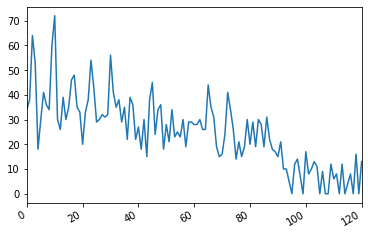

In [8]:
site_2629_meeting_data.reset_index()['Site-2629'].plot(subplots=True)                   
site_2629_meeting_data

Now we have to divide data into features and labels. For time series data features are previous obeserved values and label is the value to be predicted. Here, the number of features is called window size and a slice of the time series of length equal to window size is called a window. The following function creates a windowed dataset from the given time series. Here target_size is the number of future predicted values.

In [20]:
def windowed_data(dataframe, window_size, target_size, batch_size,shuffle=True, repeat= True):
    dataset = tf.data.Dataset.from_tensor_slices(dataframe)
    dataset = dataset.window(window_size+target_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+target_size))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda window: (window[:-target_size],window[-target_size:]))
    dataset = dataset.batch(batch_size)
    if repeat:
        dataset = dataset.repeat()
    return dataset

We have to split the data into train and validation set. We set training data size to 90. the rest of the data will be used for validation. Window size is set to 8 and future target size is set to 5.

In [21]:
TRAIN_SPLIT = 100
BATCH_SIZE = 100
REPEAT= True
window_size = 7
target_size = 5

In [22]:
site_2629_meeting_values = site_2629_meeting_data.values
site_5298_meeting_values = site_5298_meeting_data.values
site_5299_meeting_values = site_5299_meeting_data.values
site_10648_meeting_values = site_10648_meeting_data.values
site_7976_meeting_values = site_7976_meeting_data.values

site_2629_train_dataset = windowed_data(site_2629_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE, repeat = REPEAT)
site_2629_validation_dataset = windowed_data(site_2629_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE, repeat = REPEAT)


site_5298_train_dataset = windowed_data(site_5298_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE, repeat = REPEAT)
site_5298_validation_dataset = windowed_data(site_5298_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE, repeat = REPEAT)

site_5299_train_dataset = windowed_data(site_5299_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE,repeat = REPEAT)
site_5299_validation_dataset = windowed_data(site_5299_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE, repeat = REPEAT)

site_10648_train_dataset = windowed_data(site_10648_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE, repeat = REPEAT)
site_10648_validation_dataset = windowed_data(site_10648_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE,repeat = REPEAT)

site_7976_train_dataset = windowed_data(site_7976_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE, repeat = REPEAT)
site_7976_validation_dataset = windowed_data(site_7976_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE, repeat = REPEAT)

for x, y in site_2629_train_dataset.take(1):
    print('x=',x.shape, 'y=',y.shape)
   

x= (89, 7, 1) y= (89, 5, 1)


<p style="font-family: Arial; font-size:1.25em;color:#2462C0; font-style:bold">
Building and Training Model for Scenerio 1</p>

In [23]:
tf.keras.backend.clear_session()
model_2629 = tf.keras.models.Sequential()
model_2629.add(tf.keras.layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout = 0.4,
                     return_sequences=True,
                     input_shape=(None, 1)))
model_2629.add(tf.keras.layers.GRU(8,
                     dropout=0.2,
                     recurrent_dropout = 0.4,
                     return_sequences=True,
                     input_shape=(None, 1)))
model_2629.add(tf.keras.layers.GRU(8,
                     dropout=0.2 , recurrent_dropout = 0.4 ))
model_2629.add(tf.keras.layers.Dense(target_size,  activation='relu' ))


model_2629.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
history_2629 = model_2629.fit(site_2629_train_dataset,validation_data=site_2629_validation_dataset,epochs=800,
                              steps_per_epoch=50, validation_steps=50
                             )


Train for 50 steps, validate for 50 steps
Epoch 1/800
50/50 [==============================] - 5s 107ms/step - loss: 26.2913 - val_loss: 5.3474
Epoch 2/800
50/50 [==============================] - 1s 17ms/step - loss: 22.6156 - val_loss: 5.2083
Epoch 3/800
50/50 [==============================] - 1s 17ms/step - loss: 19.4654 - val_loss: 5.0780
Epoch 4/800
50/50 [==============================] - 1s 17ms/step - loss: 16.8682 - val_loss: 4.9581
Epoch 5/800
50/50 [==============================] - 1s 17ms/step - loss: 15.0078 - val_loss: 4.8916
Epoch 6/800
50/50 [==============================] - 1s 17ms/step - loss: 13.6675 - val_loss: 4.8669
Epoch 7/800
50/50 [==============================] - 1s 17ms/step - loss: 12.6899 - val_loss: 4.8538
Epoch 8/800
50/50 [==============================] - 1s 19ms/step - loss: 12.1385 - val_loss: 4.8436
Epoch 9/800
50/50 [==============================] - 1s 17ms/step - loss: 11.7811 - val_loss: 4.8352
Epoch 10/800
50/50 [============================

50/50 [==============================] - 1s 17ms/step - loss: 8.3614 - val_loss: 4.6911
Epoch 82/800
50/50 [==============================] - 1s 18ms/step - loss: 8.3971 - val_loss: 4.6915
Epoch 83/800
50/50 [==============================] - 1s 17ms/step - loss: 8.3457 - val_loss: 4.6966
Epoch 84/800
50/50 [==============================] - 1s 18ms/step - loss: 8.3827 - val_loss: 4.6963
Epoch 85/800
50/50 [==============================] - 1s 18ms/step - loss: 8.3866 - val_loss: 4.6976
Epoch 86/800
50/50 [==============================] - 1s 17ms/step - loss: 8.3039 - val_loss: 4.7044
Epoch 87/800
50/50 [==============================] - 1s 17ms/step - loss: 8.2486 - val_loss: 4.7043
Epoch 88/800
50/50 [==============================] - 1s 17ms/step - loss: 8.2896 - val_loss: 4.7109
Epoch 89/800
50/50 [==============================] - 1s 17ms/step - loss: 8.2765 - val_loss: 4.7118
Epoch 90/800
50/50 [==============================] - 1s 18ms/step - loss: 8.3796 - val_loss: 4.7124
Epo

50/50 [==============================] - 1s 19ms/step - loss: 7.8418 - val_loss: 5.2770
Epoch 162/800
50/50 [==============================] - 1s 18ms/step - loss: 7.7861 - val_loss: 5.2800
Epoch 163/800
50/50 [==============================] - 1s 19ms/step - loss: 7.7548 - val_loss: 5.2851
Epoch 164/800
50/50 [==============================] - 1s 18ms/step - loss: 7.7626 - val_loss: 5.2920
Epoch 165/800
50/50 [==============================] - 1s 17ms/step - loss: 7.7510 - val_loss: 5.3072
Epoch 166/800
50/50 [==============================] - 1s 17ms/step - loss: 7.7033 - val_loss: 5.3308
Epoch 167/800
50/50 [==============================] - 1s 20ms/step - loss: 7.7065 - val_loss: 5.3400
Epoch 168/800
50/50 [==============================] - 1s 17ms/step - loss: 7.7354 - val_loss: 5.3299
Epoch 169/800
50/50 [==============================] - 1s 23ms/step - loss: 7.7372 - val_loss: 5.3526
Epoch 170/800
50/50 [==============================] - 1s 18ms/step - loss: 7.7569 - val_loss: 5

50/50 [==============================] - 1s 19ms/step - loss: 7.6348 - val_loss: 5.8994
Epoch 242/800
50/50 [==============================] - 1s 18ms/step - loss: 7.5540 - val_loss: 5.9184
Epoch 243/800
50/50 [==============================] - 1s 18ms/step - loss: 7.5768 - val_loss: 5.9242
Epoch 244/800
50/50 [==============================] - 1s 18ms/step - loss: 7.5655 - val_loss: 5.9559
Epoch 245/800
50/50 [==============================] - 1s 18ms/step - loss: 7.5434 - val_loss: 5.9566
Epoch 246/800
50/50 [==============================] - 1s 18ms/step - loss: 7.6821 - val_loss: 5.9680
Epoch 247/800
50/50 [==============================] - 1s 18ms/step - loss: 7.5468 - val_loss: 5.9695
Epoch 248/800
50/50 [==============================] - 1s 18ms/step - loss: 7.4360 - val_loss: 5.9746
Epoch 249/800
50/50 [==============================] - 1s 18ms/step - loss: 7.5125 - val_loss: 5.9805
Epoch 250/800
50/50 [==============================] - 1s 18ms/step - loss: 7.5196 - val_loss: 5

50/50 [==============================] - 1s 20ms/step - loss: 7.4372 - val_loss: 6.3914
Epoch 322/800
50/50 [==============================] - 1s 19ms/step - loss: 7.3369 - val_loss: 6.4134
Epoch 323/800
50/50 [==============================] - 1s 17ms/step - loss: 7.4230 - val_loss: 6.4180
Epoch 324/800
50/50 [==============================] - 1s 17ms/step - loss: 7.4439 - val_loss: 6.4414
Epoch 325/800
50/50 [==============================] - 1s 18ms/step - loss: 7.3957 - val_loss: 6.4729
Epoch 326/800
50/50 [==============================] - 1s 19ms/step - loss: 7.4023 - val_loss: 6.4623
Epoch 327/800
50/50 [==============================] - 1s 20ms/step - loss: 7.4284 - val_loss: 6.4661
Epoch 328/800
50/50 [==============================] - 1s 18ms/step - loss: 7.4811 - val_loss: 6.4658
Epoch 329/800
50/50 [==============================] - 1s 17ms/step - loss: 7.4444 - val_loss: 6.4913
Epoch 330/800
50/50 [==============================] - 1s 19ms/step - loss: 7.4485 - val_loss: 6

50/50 [==============================] - 1s 18ms/step - loss: 7.2757 - val_loss: 6.9050
Epoch 402/800
50/50 [==============================] - 1s 18ms/step - loss: 7.3586 - val_loss: 6.9181
Epoch 403/800
50/50 [==============================] - 1s 20ms/step - loss: 7.3219 - val_loss: 6.9175
Epoch 404/800
50/50 [==============================] - 1s 21ms/step - loss: 7.3362 - val_loss: 6.9280
Epoch 405/800
50/50 [==============================] - 1s 20ms/step - loss: 7.2516 - val_loss: 6.9437
Epoch 406/800
50/50 [==============================] - 1s 21ms/step - loss: 7.2812 - val_loss: 6.9204
Epoch 407/800
50/50 [==============================] - 1s 21ms/step - loss: 7.3037 - val_loss: 6.9326
Epoch 408/800
50/50 [==============================] - 1s 21ms/step - loss: 7.3263 - val_loss: 6.9350
Epoch 409/800
50/50 [==============================] - 1s 21ms/step - loss: 7.3316 - val_loss: 6.9563
Epoch 410/800
50/50 [==============================] - 1s 21ms/step - loss: 7.3126 - val_loss: 6

50/50 [==============================] - 1s 19ms/step - loss: 7.3142 - val_loss: 7.5134
Epoch 482/800
50/50 [==============================] - 1s 18ms/step - loss: 7.2737 - val_loss: 7.4882
Epoch 483/800
50/50 [==============================] - 1s 18ms/step - loss: 7.2288 - val_loss: 7.5044
Epoch 484/800
50/50 [==============================] - 1s 17ms/step - loss: 7.2639 - val_loss: 7.5510
Epoch 485/800
50/50 [==============================] - 1s 17ms/step - loss: 7.2228 - val_loss: 7.5503
Epoch 486/800
50/50 [==============================] - 1s 19ms/step - loss: 7.1530 - val_loss: 7.5367
Epoch 487/800
50/50 [==============================] - 1s 17ms/step - loss: 7.2162 - val_loss: 7.5221
Epoch 488/800
50/50 [==============================] - 1s 17ms/step - loss: 7.2551 - val_loss: 7.5564
Epoch 489/800
50/50 [==============================] - 1s 18ms/step - loss: 7.2005 - val_loss: 7.5471
Epoch 490/800
50/50 [==============================] - 1s 18ms/step - loss: 7.2746 - val_loss: 7

50/50 [==============================] - 1s 29ms/step - loss: 7.1916 - val_loss: 8.0249
Epoch 562/800
50/50 [==============================] - 2s 30ms/step - loss: 7.1646 - val_loss: 8.0413
Epoch 563/800
50/50 [==============================] - 1s 29ms/step - loss: 7.1582 - val_loss: 8.0396
Epoch 564/800
50/50 [==============================] - 1s 27ms/step - loss: 7.1761 - val_loss: 8.0736
Epoch 565/800
50/50 [==============================] - 1s 28ms/step - loss: 7.1789 - val_loss: 8.0784
Epoch 566/800
50/50 [==============================] - 1s 28ms/step - loss: 7.1496 - val_loss: 8.0609
Epoch 567/800
50/50 [==============================] - 1s 26ms/step - loss: 7.1721 - val_loss: 8.0532
Epoch 568/800
50/50 [==============================] - 1s 25ms/step - loss: 7.1342 - val_loss: 8.0812
Epoch 569/800
50/50 [==============================] - 1s 25ms/step - loss: 7.2014 - val_loss: 8.0908
Epoch 570/800
50/50 [==============================] - 1s 25ms/step - loss: 7.2143 - val_loss: 8

50/50 [==============================] - 1s 18ms/step - loss: 7.0890 - val_loss: 8.4913
Epoch 642/800
50/50 [==============================] - 1s 17ms/step - loss: 7.1567 - val_loss: 8.5136
Epoch 643/800
50/50 [==============================] - 1s 18ms/step - loss: 7.0907 - val_loss: 8.4905
Epoch 644/800
50/50 [==============================] - 1s 18ms/step - loss: 7.1110 - val_loss: 8.4732
Epoch 645/800
50/50 [==============================] - 1s 18ms/step - loss: 7.1233 - val_loss: 8.5275
Epoch 646/800
50/50 [==============================] - 1s 17ms/step - loss: 7.1026 - val_loss: 8.5640
Epoch 647/800
50/50 [==============================] - 1s 23ms/step - loss: 7.0660 - val_loss: 8.5066
Epoch 648/800
50/50 [==============================] - 1s 17ms/step - loss: 7.0529 - val_loss: 8.5733
Epoch 649/800
50/50 [==============================] - 1s 18ms/step - loss: 7.0596 - val_loss: 8.5383
Epoch 650/800
50/50 [==============================] - 1s 17ms/step - loss: 7.0883 - val_loss: 8

50/50 [==============================] - 1s 17ms/step - loss: 6.9696 - val_loss: 8.6232
Epoch 722/800
50/50 [==============================] - 1s 17ms/step - loss: 6.9588 - val_loss: 8.6268
Epoch 723/800
50/50 [==============================] - 1s 21ms/step - loss: 6.9485 - val_loss: 8.4909
Epoch 724/800
50/50 [==============================] - 1s 21ms/step - loss: 6.9521 - val_loss: 8.5633
Epoch 725/800
50/50 [==============================] - 1s 19ms/step - loss: 6.9856 - val_loss: 8.5107
Epoch 726/800
50/50 [==============================] - 1s 20ms/step - loss: 6.9112 - val_loss: 8.5180
Epoch 727/800
50/50 [==============================] - 1s 17ms/step - loss: 6.9427 - val_loss: 8.5096
Epoch 728/800
50/50 [==============================] - 1s 19ms/step - loss: 6.9937 - val_loss: 8.5120
Epoch 729/800
50/50 [==============================] - 1s 20ms/step - loss: 6.9742 - val_loss: 8.5126
Epoch 730/800
50/50 [==============================] - 1s 17ms/step - loss: 6.9333 - val_loss: 8

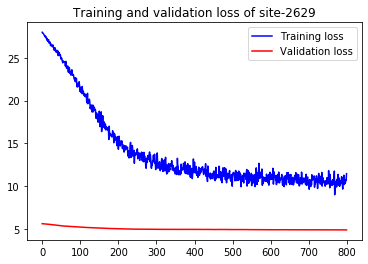

In [16]:
plot_train_history(history_2629, 'Training and validation loss of site-2629')

Now we can make prediction for next 30 days after p-day by using the below function.

In [64]:
site_2629_forcast_1=p_day_forecast_scene_1(model_2629, site_2629_meeting_data,'Site_2629', window_size, target_size)
site_2629_forcast_1
site_2629_forcast_1.to_csv( base_dir + r'/prediction/site_2629_forcast_1.csv',index=False)

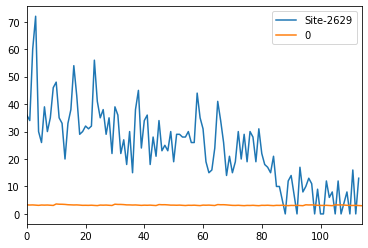

In [19]:
plot_forecast_scene_1(model_2629 ,site_2629_meeting_data,'Site-2629', window_size,target_size)

Model for site-5298

In [67]:
tf.keras.backend.clear_session()
model_5298 = tf.keras.models.Sequential()
model_5298.add(tf.keras.layers.GRU(128,
                     dropout=0.01,
                     recurrent_dropout=0.01,
                     return_sequences=True,
                     input_shape=(None, 1)))
model_5298.add(tf.keras.layers.GRU(128,
                     dropout=0.01,
                     recurrent_dropout=0.01,
                     activation='relu'))
model_5298.add(tf.keras.layers.Dense(target_size,  activation='relu' ))


model_5298.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
history_5298 = model_5298.fit_generator(site_5298_train_dataset,
#                               steps_per_epoch=200,
                              epochs=600,
                              validation_data=site_5298_validation_dataset,
#                               validation_steps=200
                             )

Epoch 1/600
2/2 [==============================] - 0s 115ms/step - loss: 50.6328 - val_loss: 0.0000e+00
Epoch 2/600
2/2 [==============================] - 0s 107ms/step - loss: 48.3555 - val_loss: 8.4081
Epoch 3/600
2/2 [==============================] - 0s 105ms/step - loss: 40.6688 - val_loss: 15.5921
Epoch 4/600
2/2 [==============================] - 0s 114ms/step - loss: 28.5654 - val_loss: 9.1758
Epoch 5/600
2/2 [==============================] - 0s 107ms/step - loss: 26.7208 - val_loss: 10.6191
Epoch 6/600
2/2 [==============================] - 0s 105ms/step - loss: 24.3223 - val_loss: 8.9192
Epoch 7/600
2/2 [==============================] - 0s 111ms/step - loss: 24.5702 - val_loss: 7.6820
Epoch 8/600
2/2 [==============================] - 0s 106ms/step - loss: 23.6031 - val_loss: 7.7438
Epoch 9/600
2/2 [==============================] - 0s 111ms/step - loss: 23.5464 - val_loss: 7.6839
Epoch 10/600
2/2 [==============================] - 0s 161ms/step - loss: 24.7033 - val_loss: 

Epoch 82/600
2/2 [==============================] - 0s 100ms/step - loss: 22.7590 - val_loss: 9.8954
Epoch 83/600
2/2 [==============================] - 0s 101ms/step - loss: 22.1159 - val_loss: 9.6611
Epoch 84/600
2/2 [==============================] - 0s 99ms/step - loss: 21.4801 - val_loss: 9.4749
Epoch 85/600
2/2 [==============================] - 0s 99ms/step - loss: 21.6662 - val_loss: 9.5665
Epoch 86/600
2/2 [==============================] - 0s 100ms/step - loss: 21.1074 - val_loss: 9.3843
Epoch 87/600
2/2 [==============================] - 0s 100ms/step - loss: 21.3201 - val_loss: 9.3251
Epoch 88/600
2/2 [==============================] - 0s 100ms/step - loss: 20.9136 - val_loss: 9.6202
Epoch 89/600
2/2 [==============================] - 0s 102ms/step - loss: 20.9696 - val_loss: 9.4236
Epoch 90/600
2/2 [==============================] - 0s 98ms/step - loss: 20.9662 - val_loss: 9.4319
Epoch 91/600
2/2 [==============================] - 0s 99ms/step - loss: 21.5487 - val_loss: 9

Epoch 163/600
2/2 [==============================] - 0s 101ms/step - loss: 9.8215 - val_loss: 8.8263
Epoch 164/600
2/2 [==============================] - 0s 99ms/step - loss: 11.8667 - val_loss: 8.7552
Epoch 165/600
2/2 [==============================] - 0s 99ms/step - loss: 12.0925 - val_loss: 8.8150
Epoch 166/600
2/2 [==============================] - 0s 103ms/step - loss: 9.8426 - val_loss: 8.6135
Epoch 167/600
2/2 [==============================] - 0s 100ms/step - loss: 9.5819 - val_loss: 8.7184
Epoch 168/600
2/2 [==============================] - 0s 101ms/step - loss: 9.8264 - val_loss: 8.8968
Epoch 169/600
2/2 [==============================] - 0s 99ms/step - loss: 11.4148 - val_loss: 8.8392
Epoch 170/600
2/2 [==============================] - 0s 99ms/step - loss: 12.4084 - val_loss: 8.8086
Epoch 171/600
2/2 [==============================] - 0s 99ms/step - loss: 10.6874 - val_loss: 8.7625
Epoch 172/600
2/2 [==============================] - 0s 97ms/step - loss: 10.7842 - val_los

2/2 [==============================] - 0s 100ms/step - loss: 7.6261 - val_loss: 8.4596
Epoch 326/600
2/2 [==============================] - 0s 100ms/step - loss: 11.0755 - val_loss: 8.5227
Epoch 327/600
2/2 [==============================] - 0s 98ms/step - loss: 7.2055 - val_loss: 8.5308
Epoch 328/600
2/2 [==============================] - 0s 101ms/step - loss: 6.6631 - val_loss: 8.6647
Epoch 329/600
2/2 [==============================] - 0s 100ms/step - loss: 7.0184 - val_loss: 8.5124
Epoch 330/600
2/2 [==============================] - 0s 100ms/step - loss: 8.8658 - val_loss: 8.6538
Epoch 331/600
2/2 [==============================] - 0s 100ms/step - loss: 10.3309 - val_loss: 8.5653
Epoch 332/600
2/2 [==============================] - 0s 99ms/step - loss: 7.6967 - val_loss: 8.6218
Epoch 333/600
2/2 [==============================] - 0s 99ms/step - loss: 7.9556 - val_loss: 8.7751
Epoch 334/600
2/2 [==============================] - 0s 105ms/step - loss: 6.4077 - val_loss: 8.7100
Epoch

2/2 [==============================] - 0s 99ms/step - loss: 6.4979 - val_loss: 9.0957
Epoch 488/600
2/2 [==============================] - 0s 99ms/step - loss: 6.4132 - val_loss: 8.9926
Epoch 489/600
2/2 [==============================] - 0s 100ms/step - loss: 5.8168 - val_loss: 8.9925
Epoch 490/600
2/2 [==============================] - 0s 101ms/step - loss: 4.9195 - val_loss: 8.9085
Epoch 491/600
2/2 [==============================] - 0s 99ms/step - loss: 5.3042 - val_loss: 8.8417
Epoch 492/600
2/2 [==============================] - 0s 99ms/step - loss: 6.7560 - val_loss: 8.8587
Epoch 493/600
2/2 [==============================] - 0s 100ms/step - loss: 6.7040 - val_loss: 9.2317
Epoch 494/600
2/2 [==============================] - 0s 100ms/step - loss: 6.2596 - val_loss: 8.7563
Epoch 495/600
2/2 [==============================] - 0s 100ms/step - loss: 6.2661 - val_loss: 8.9799
Epoch 496/600
2/2 [==============================] - 0s 98ms/step - loss: 5.2800 - val_loss: 9.0047
Epoch 497

In [14]:
plot_train_history(history_5298, 'Training and validation loss of site-5298')

NameError: name 'plot_train_history' is not defined

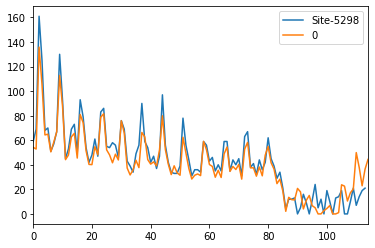

In [69]:
plot_forecast(model_5298 ,site_5298_meeting_data,'Site-5298', window_size,target_size)

In [70]:


site_5298_forcast_1
site_5298_forcast_1.to_csv(base_dir + r'/prediction/site_5298_forcast_1.csv',index=False)

Model of site-5299

In [83]:
tf.keras.backend.clear_session()
model_5299 = tf.keras.models.Sequential()
model_5299.add(tf.keras.layers.GRU(128,
                     dropout=0.1,
#                      recurrent_dropout=0.1,
                     return_sequences=True,
                     input_shape=(None, 1)))
model_5299.add(tf.keras.layers.GRU(64,
                     dropout=0.1,
#                      recurrent_dropout=0.1,
                     activation='relu'))
model_5299.add(tf.keras.layers.Dense(target_size,  activation='relu' ))

model_5299.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
history_5299 = model_5299.fit_generator(site_5299_train_dataset,
                              epochs=600,
                              validation_data=site_5299_validation_dataset,
                             )

Epoch 1/600
2/2 [==============================] - 0s 88ms/step - loss: 19.4646 - val_loss: 0.0000e+00
Epoch 2/600
2/2 [==============================] - 0s 82ms/step - loss: 18.8906 - val_loss: 7.3192
Epoch 3/600
2/2 [==============================] - 0s 85ms/step - loss: 18.0359 - val_loss: 6.3938
Epoch 4/600
2/2 [==============================] - 0s 85ms/step - loss: 16.6630 - val_loss: 6.5975
Epoch 5/600
2/2 [==============================] - 0s 133ms/step - loss: 15.1091 - val_loss: 10.6100
Epoch 6/600
2/2 [==============================] - 0s 103ms/step - loss: 14.5512 - val_loss: 7.9075
Epoch 7/600
2/2 [==============================] - 0s 81ms/step - loss: 13.7510 - val_loss: 9.6713
Epoch 8/600
2/2 [==============================] - 0s 88ms/step - loss: 13.4728 - val_loss: 7.2502
Epoch 9/600
2/2 [==============================] - 0s 85ms/step - loss: 13.2732 - val_loss: 5.9409
Epoch 10/600
2/2 [==============================] - 0s 86ms/step - loss: 13.2344 - val_loss: 7.8593
Ep

Epoch 83/600
2/2 [==============================] - 0s 76ms/step - loss: 11.4638 - val_loss: 5.7433
Epoch 84/600
2/2 [==============================] - 0s 78ms/step - loss: 11.3900 - val_loss: 6.1236
Epoch 85/600
2/2 [==============================] - 0s 77ms/step - loss: 11.1882 - val_loss: 5.7584
Epoch 86/600
2/2 [==============================] - 0s 77ms/step - loss: 11.2462 - val_loss: 6.0761
Epoch 87/600
2/2 [==============================] - 0s 78ms/step - loss: 11.2261 - val_loss: 5.8592
Epoch 88/600
2/2 [==============================] - 0s 78ms/step - loss: 10.9872 - val_loss: 5.7358
Epoch 89/600
2/2 [==============================] - 0s 79ms/step - loss: 10.9126 - val_loss: 5.7775
Epoch 90/600
2/2 [==============================] - 0s 77ms/step - loss: 10.9640 - val_loss: 5.9724
Epoch 91/600
2/2 [==============================] - 0s 77ms/step - loss: 11.8069 - val_loss: 5.8982
Epoch 92/600
2/2 [==============================] - 0s 76ms/step - loss: 11.1053 - val_loss: 5.8869


Epoch 246/600
2/2 [==============================] - 0s 78ms/step - loss: 7.6899 - val_loss: 7.1407
Epoch 247/600
2/2 [==============================] - 0s 79ms/step - loss: 7.8236 - val_loss: 7.0919
Epoch 248/600
2/2 [==============================] - 0s 77ms/step - loss: 7.9274 - val_loss: 6.6974
Epoch 249/600
2/2 [==============================] - 0s 77ms/step - loss: 7.0764 - val_loss: 6.9121
Epoch 250/600
2/2 [==============================] - 0s 77ms/step - loss: 7.4072 - val_loss: 6.9479
Epoch 251/600
2/2 [==============================] - 0s 77ms/step - loss: 7.4870 - val_loss: 6.3504
Epoch 252/600
2/2 [==============================] - 0s 79ms/step - loss: 7.6518 - val_loss: 6.3088
Epoch 253/600
2/2 [==============================] - 0s 77ms/step - loss: 8.1837 - val_loss: 6.8660
Epoch 254/600
2/2 [==============================] - 0s 78ms/step - loss: 7.6909 - val_loss: 7.1293
Epoch 255/600
2/2 [==============================] - 0s 78ms/step - loss: 7.3253 - val_loss: 6.7520


Epoch 328/600
2/2 [==============================] - 0s 80ms/step - loss: 6.9500 - val_loss: 7.3258
Epoch 329/600
2/2 [==============================] - 0s 79ms/step - loss: 6.0795 - val_loss: 7.0970
Epoch 330/600
2/2 [==============================] - 0s 82ms/step - loss: 6.2352 - val_loss: 7.0714
Epoch 331/600
2/2 [==============================] - 0s 78ms/step - loss: 6.8097 - val_loss: 7.0185
Epoch 332/600
2/2 [==============================] - 0s 79ms/step - loss: 6.3389 - val_loss: 6.9172
Epoch 333/600
2/2 [==============================] - 0s 79ms/step - loss: 6.1087 - val_loss: 7.1271
Epoch 334/600
2/2 [==============================] - 0s 79ms/step - loss: 6.6365 - val_loss: 7.3670
Epoch 335/600
2/2 [==============================] - 0s 79ms/step - loss: 5.9229 - val_loss: 7.3130
Epoch 336/600
2/2 [==============================] - 0s 79ms/step - loss: 6.0696 - val_loss: 7.2546
Epoch 337/600
2/2 [==============================] - 0s 78ms/step - loss: 6.3335 - val_loss: 7.2205


Epoch 410/600
2/2 [==============================] - 0s 82ms/step - loss: 5.5906 - val_loss: 7.2784
Epoch 411/600
2/2 [==============================] - 0s 81ms/step - loss: 5.6286 - val_loss: 7.4795
Epoch 412/600
2/2 [==============================] - 0s 78ms/step - loss: 5.4545 - val_loss: 7.2638
Epoch 413/600
2/2 [==============================] - 0s 81ms/step - loss: 5.6165 - val_loss: 7.1620
Epoch 414/600
2/2 [==============================] - 0s 79ms/step - loss: 6.3106 - val_loss: 7.2244
Epoch 415/600
2/2 [==============================] - 0s 78ms/step - loss: 5.1080 - val_loss: 7.0213
Epoch 416/600
2/2 [==============================] - 0s 79ms/step - loss: 5.6175 - val_loss: 7.3924
Epoch 417/600
2/2 [==============================] - 0s 83ms/step - loss: 5.6685 - val_loss: 7.4074
Epoch 418/600
2/2 [==============================] - 0s 83ms/step - loss: 6.2819 - val_loss: 7.3710
Epoch 419/600
2/2 [==============================] - 0s 82ms/step - loss: 5.3729 - val_loss: 7.3396


Epoch 492/600
2/2 [==============================] - 0s 78ms/step - loss: 4.6640 - val_loss: 7.0237
Epoch 493/600
2/2 [==============================] - 0s 79ms/step - loss: 5.0047 - val_loss: 7.4871
Epoch 494/600
2/2 [==============================] - 0s 77ms/step - loss: 5.5618 - val_loss: 7.3579
Epoch 495/600
2/2 [==============================] - 0s 76ms/step - loss: 5.3496 - val_loss: 7.0649
Epoch 496/600
2/2 [==============================] - 0s 83ms/step - loss: 4.7350 - val_loss: 7.1408
Epoch 497/600
2/2 [==============================] - 0s 104ms/step - loss: 5.1035 - val_loss: 7.1253
Epoch 498/600
2/2 [==============================] - 0s 77ms/step - loss: 4.6254 - val_loss: 6.9317
Epoch 499/600
2/2 [==============================] - 0s 78ms/step - loss: 4.4581 - val_loss: 7.1009
Epoch 500/600
2/2 [==============================] - 0s 78ms/step - loss: 5.3549 - val_loss: 7.1681
Epoch 501/600
2/2 [==============================] - 0s 78ms/step - loss: 4.7476 - val_loss: 6.9425

Epoch 574/600
2/2 [==============================] - 0s 79ms/step - loss: 3.9249 - val_loss: 7.2413
Epoch 575/600
2/2 [==============================] - 0s 78ms/step - loss: 4.3332 - val_loss: 7.0739
Epoch 576/600
2/2 [==============================] - 0s 77ms/step - loss: 4.2879 - val_loss: 7.0960
Epoch 577/600
2/2 [==============================] - 0s 78ms/step - loss: 4.1223 - val_loss: 7.1695
Epoch 578/600
2/2 [==============================] - 0s 77ms/step - loss: 4.4378 - val_loss: 6.9746
Epoch 579/600
2/2 [==============================] - 0s 77ms/step - loss: 4.7737 - val_loss: 6.9870
Epoch 580/600
2/2 [==============================] - 0s 78ms/step - loss: 4.7946 - val_loss: 6.9056
Epoch 581/600
2/2 [==============================] - 0s 78ms/step - loss: 4.3984 - val_loss: 6.9772
Epoch 582/600
2/2 [==============================] - 0s 77ms/step - loss: 3.9196 - val_loss: 7.0860
Epoch 583/600
2/2 [==============================] - 0s 77ms/step - loss: 4.5107 - val_loss: 7.3295


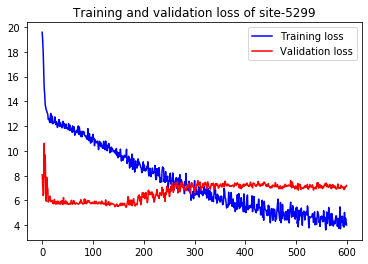

In [85]:
plot_train_history(history_5299, 'Training and validation loss of site-5299')

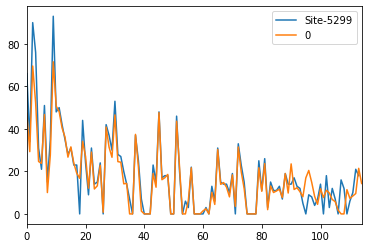

In [86]:
plot_forecast(model_5299 ,site_5299_meeting_data,'Site-5299', window_size,target_size)

In [87]:
site_5299_forcast_1=p_day_forecast(model_5299, site_5299_meeting_data,'Site_5299', window_size, target_size)
site_5299_forcast_1
site_5299_forcast_1.to_csv( base_dir + r'/prediction/site_5299_forcast_1.csv',index=False)

Model of Site-10648

In [100]:
tf.keras.backend.clear_session()
model_10648 = tf.keras.models.Sequential()
model_10648.add(tf.keras.layers.GRU(32,
                     dropout=0.1,
#                      recurrent_dropout=0.1,
                     return_sequences=True,
                     input_shape=(None, 1)))
model_10648.add(tf.keras.layers.GRU(32,
                     dropout=0.1,
#                      recurrent_dropout=0.1,
                     activation='relu'))
model_10648.add(tf.keras.layers.Dense(target_size,  activation='relu' ))


model_10648.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
history_10648 = model_10648.fit_generator(site_10648_train_dataset,
#                               steps_per_epoch=200,
                              epochs=600,
                              validation_data=site_10648_validation_dataset,
#                               validation_steps=200
                             )

Epoch 1/600
2/2 [==============================] - 0s 86ms/step - loss: 18.4308 - val_loss: 0.0000e+00
Epoch 2/600
2/2 [==============================] - 0s 75ms/step - loss: 18.7236 - val_loss: 5.4163
Epoch 3/600
2/2 [==============================] - 0s 76ms/step - loss: 18.5866 - val_loss: 5.4265
Epoch 4/600
2/2 [==============================] - 0s 73ms/step - loss: 18.5142 - val_loss: 5.4357
Epoch 5/600
2/2 [==============================] - 0s 73ms/step - loss: 18.6639 - val_loss: 5.4496
Epoch 6/600
2/2 [==============================] - 0s 76ms/step - loss: 18.4553 - val_loss: 5.4638
Epoch 7/600
2/2 [==============================] - 0s 80ms/step - loss: 18.5103 - val_loss: 5.4777
Epoch 8/600
2/2 [==============================] - 0s 75ms/step - loss: 18.5855 - val_loss: 5.4931
Epoch 9/600
2/2 [==============================] - 0s 76ms/step - loss: 18.5599 - val_loss: 5.5070
Epoch 10/600
2/2 [==============================] - 0s 77ms/step - loss: 18.0345 - val_loss: 5.5305
Epoch

Epoch 83/600
2/2 [==============================] - 0s 71ms/step - loss: 15.4579 - val_loss: 5.5652
Epoch 84/600
2/2 [==============================] - 0s 71ms/step - loss: 15.3220 - val_loss: 5.5714
Epoch 85/600
2/2 [==============================] - 0s 70ms/step - loss: 15.3202 - val_loss: 5.5514
Epoch 86/600
2/2 [==============================] - 0s 71ms/step - loss: 16.0868 - val_loss: 5.5616
Epoch 87/600
2/2 [==============================] - 0s 71ms/step - loss: 16.2472 - val_loss: 5.5575
Epoch 88/600
2/2 [==============================] - 0s 70ms/step - loss: 15.7788 - val_loss: 5.5740
Epoch 89/600
2/2 [==============================] - 0s 70ms/step - loss: 15.9316 - val_loss: 5.5664
Epoch 90/600
2/2 [==============================] - 0s 71ms/step - loss: 15.6904 - val_loss: 5.5839
Epoch 91/600
2/2 [==============================] - 0s 70ms/step - loss: 15.8462 - val_loss: 5.5768
Epoch 92/600
2/2 [==============================] - 0s 71ms/step - loss: 15.8840 - val_loss: 5.5644


2/2 [==============================] - 0s 73ms/step - loss: 12.9068 - val_loss: 6.0997
Epoch 246/600
2/2 [==============================] - 0s 87ms/step - loss: 13.6288 - val_loss: 6.0012
Epoch 247/600
2/2 [==============================] - 0s 102ms/step - loss: 12.7706 - val_loss: 5.9490
Epoch 248/600
2/2 [==============================] - 0s 75ms/step - loss: 12.7761 - val_loss: 6.0713
Epoch 249/600
2/2 [==============================] - 0s 70ms/step - loss: 12.7049 - val_loss: 6.0623
Epoch 250/600
2/2 [==============================] - 0s 68ms/step - loss: 13.0473 - val_loss: 6.0133
Epoch 251/600
2/2 [==============================] - 0s 74ms/step - loss: 13.1333 - val_loss: 5.9381
Epoch 252/600
2/2 [==============================] - 0s 98ms/step - loss: 14.1332 - val_loss: 6.1147
Epoch 253/600
2/2 [==============================] - 0s 95ms/step - loss: 13.3018 - val_loss: 5.9920
Epoch 254/600
2/2 [==============================] - 0s 73ms/step - loss: 13.2644 - val_loss: 6.1604
Epo

2/2 [==============================] - 0s 75ms/step - loss: 11.5920 - val_loss: 6.6831
Epoch 408/600
2/2 [==============================] - 0s 99ms/step - loss: 11.0848 - val_loss: 6.5903
Epoch 409/600
2/2 [==============================] - 0s 91ms/step - loss: 11.1582 - val_loss: 6.7349
Epoch 410/600
2/2 [==============================] - 0s 102ms/step - loss: 11.7528 - val_loss: 6.5330
Epoch 411/600
2/2 [==============================] - 0s 75ms/step - loss: 10.8560 - val_loss: 6.6075
Epoch 412/600
2/2 [==============================] - 0s 98ms/step - loss: 11.1854 - val_loss: 6.5590
Epoch 413/600
2/2 [==============================] - 0s 87ms/step - loss: 11.6857 - val_loss: 6.5980
Epoch 414/600
2/2 [==============================] - 0s 75ms/step - loss: 11.6653 - val_loss: 6.6164
Epoch 415/600
2/2 [==============================] - 0s 71ms/step - loss: 12.0890 - val_loss: 6.9159
Epoch 416/600
2/2 [==============================] - 0s 72ms/step - loss: 13.6267 - val_loss: 6.4522
Epo

2/2 [==============================] - 0s 67ms/step - loss: 10.2797 - val_loss: 6.9267
Epoch 570/600
2/2 [==============================] - 0s 68ms/step - loss: 10.7610 - val_loss: 6.6333
Epoch 571/600
2/2 [==============================] - 0s 67ms/step - loss: 10.0264 - val_loss: 6.6729
Epoch 572/600
2/2 [==============================] - 0s 70ms/step - loss: 10.2094 - val_loss: 6.3019
Epoch 573/600
2/2 [==============================] - 0s 67ms/step - loss: 10.1835 - val_loss: 6.9305
Epoch 574/600
2/2 [==============================] - 0s 70ms/step - loss: 10.4240 - val_loss: 6.8390
Epoch 575/600
2/2 [==============================] - 0s 69ms/step - loss: 10.3258 - val_loss: 6.8125
Epoch 576/600
2/2 [==============================] - 0s 69ms/step - loss: 10.3568 - val_loss: 7.4273
Epoch 577/600
2/2 [==============================] - 0s 69ms/step - loss: 10.0451 - val_loss: 6.8379
Epoch 578/600
2/2 [==============================] - 0s 67ms/step - loss: 9.7866 - val_loss: 7.2111
Epoch

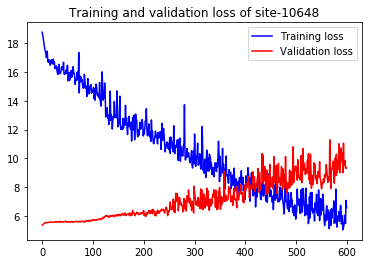

In [97]:
plot_train_history(history_10648, 'Training and validation loss of site-10648')

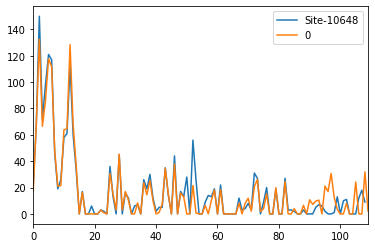

In [98]:
plot_forecast(model_10648 ,site_10648_meeting_data,'Site-10648', window_size,target_size)

In [99]:
site_10648_forcast_1=p_day_forecast(model_10648, site_10648_meeting_data,'Site_10648', window_size, target_size)
site_10648_forcast_1
# site_10648_forcast_1.to_csv( base_dir + r'/prediction/site_10648_forcast_1.csv',index=False)

,Scenario,Site,Timestep,Value
0,Scenario 1,Site_10648,2022-07-15,9.0
1,Scenario 1,Site_10648,2022-07-16,22.0
2,Scenario 1,Site_10648,2022-07-17,11.0
3,Scenario 1,Site_10648,2022-07-18,23.0
4,Scenario 1,Site_10648,2022-07-19,0.0
5,Scenario 1,Site_10648,2022-07-20,0.0
6,Scenario 1,Site_10648,2022-07-21,1.0
7,Scenario 1,Site_10648,2022-07-22,0.0
8,Scenario 1,Site_10648,2022-07-23,0.0
9,Scenario 1,Site_10648,2022-07-24,6.0


Model of Site-7976

In [101]:
tf.keras.backend.clear_session()
model_7976 = tf.keras.models.Sequential()
model_7976.add(tf.keras.layers.GRU(128,
                     dropout=0.1,
                     recurrent_dropout=0.1,
                     return_sequences=True,
                     input_shape=(None, 1)))
model_7976.add(tf.keras.layers.GRU(128,
                     dropout=0.1,
                     recurrent_dropout=0.1,
                     activation='relu'))
model_7976.add(tf.keras.layers.Dense(target_size,  activation='relu' ))


model_7976.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
history_7976 = model_7976.fit_generator(site_7976_train_dataset,
#                               steps_per_epoch=200,
                              epochs=600,
                              validation_data=site_7976_validation_dataset,
#                               validation_steps=200
                             )

Epoch 1/600
2/2 [==============================] - 0s 117ms/step - loss: 9.2497 - val_loss: 0.0000e+00
Epoch 2/600
2/2 [==============================] - 0s 105ms/step - loss: 7.5972 - val_loss: 3.5482
Epoch 3/600
2/2 [==============================] - 0s 107ms/step - loss: 5.5815 - val_loss: 2.1741
Epoch 4/600
2/2 [==============================] - 0s 113ms/step - loss: 5.0064 - val_loss: 2.0337
Epoch 5/600
2/2 [==============================] - 0s 104ms/step - loss: 4.4211 - val_loss: 2.1341
Epoch 6/600
2/2 [==============================] - 0s 107ms/step - loss: 4.4931 - val_loss: 2.0358
Epoch 7/600
2/2 [==============================] - 0s 106ms/step - loss: 4.7955 - val_loss: 2.0560
Epoch 8/600
2/2 [==============================] - 0s 104ms/step - loss: 5.0751 - val_loss: 2.0320
Epoch 9/600
2/2 [==============================] - 0s 104ms/step - loss: 4.1792 - val_loss: 2.0821
Epoch 10/600
2/2 [==============================] - 0s 103ms/step - loss: 4.5260 - val_loss: 2.0694
Epoch

Epoch 83/600
2/2 [==============================] - 0s 107ms/step - loss: 3.8132 - val_loss: 2.0935
Epoch 84/600
2/2 [==============================] - 0s 105ms/step - loss: 3.8202 - val_loss: 2.1640
Epoch 85/600
2/2 [==============================] - 0s 101ms/step - loss: 3.8648 - val_loss: 1.9219
Epoch 86/600
2/2 [==============================] - 0s 103ms/step - loss: 3.8333 - val_loss: 1.8956
Epoch 87/600
2/2 [==============================] - 0s 103ms/step - loss: 3.7893 - val_loss: 1.9428
Epoch 88/600
2/2 [==============================] - 0s 103ms/step - loss: 3.7644 - val_loss: 2.1370
Epoch 89/600
2/2 [==============================] - 0s 104ms/step - loss: 4.1546 - val_loss: 2.2628
Epoch 90/600
2/2 [==============================] - 0s 102ms/step - loss: 3.8528 - val_loss: 2.0630
Epoch 91/600
2/2 [==============================] - 0s 123ms/step - loss: 3.7159 - val_loss: 1.9227
Epoch 92/600
2/2 [==============================] - 0s 127ms/step - loss: 3.7602 - val_loss: 1.9743


2/2 [==============================] - 0s 118ms/step - loss: 3.2717 - val_loss: 2.8892
Epoch 246/600
2/2 [==============================] - 0s 106ms/step - loss: 3.1269 - val_loss: 2.9515
Epoch 247/600
2/2 [==============================] - 0s 103ms/step - loss: 3.1623 - val_loss: 2.7566
Epoch 248/600
2/2 [==============================] - 0s 110ms/step - loss: 3.0632 - val_loss: 2.8032
Epoch 249/600
2/2 [==============================] - 0s 128ms/step - loss: 3.1360 - val_loss: 2.8338
Epoch 250/600
2/2 [==============================] - 0s 106ms/step - loss: 3.0830 - val_loss: 2.9708
Epoch 251/600
2/2 [==============================] - 0s 103ms/step - loss: 3.0086 - val_loss: 2.5800
Epoch 252/600
2/2 [==============================] - 0s 105ms/step - loss: 3.2085 - val_loss: 2.7429
Epoch 253/600
2/2 [==============================] - 0s 130ms/step - loss: 3.0412 - val_loss: 2.5998
Epoch 254/600
2/2 [==============================] - 0s 122ms/step - loss: 3.2679 - val_loss: 2.6874
Epoc

2/2 [==============================] - 0s 103ms/step - loss: 2.2529 - val_loss: 2.8026
Epoch 408/600
2/2 [==============================] - 0s 105ms/step - loss: 2.0474 - val_loss: 2.9441
Epoch 409/600
2/2 [==============================] - 0s 105ms/step - loss: 2.0226 - val_loss: 2.8461
Epoch 410/600
2/2 [==============================] - 0s 103ms/step - loss: 1.9728 - val_loss: 2.8867
Epoch 411/600
2/2 [==============================] - 0s 104ms/step - loss: 2.2056 - val_loss: 2.8087
Epoch 412/600
2/2 [==============================] - 0s 103ms/step - loss: 2.2397 - val_loss: 2.9879
Epoch 413/600
2/2 [==============================] - 0s 106ms/step - loss: 2.1894 - val_loss: 2.8796
Epoch 414/600
2/2 [==============================] - 0s 106ms/step - loss: 2.0547 - val_loss: 2.8899
Epoch 415/600
2/2 [==============================] - 0s 104ms/step - loss: 2.1679 - val_loss: 3.0160
Epoch 416/600
2/2 [==============================] - 0s 104ms/step - loss: 1.8135 - val_loss: 2.9814
Epoc

2/2 [==============================] - 0s 104ms/step - loss: 1.4306 - val_loss: 2.7375
Epoch 570/600
2/2 [==============================] - 0s 106ms/step - loss: 1.4576 - val_loss: 2.7680
Epoch 571/600
2/2 [==============================] - 0s 103ms/step - loss: 1.4202 - val_loss: 2.8520
Epoch 572/600
2/2 [==============================] - 0s 105ms/step - loss: 1.4523 - val_loss: 2.6788
Epoch 573/600
2/2 [==============================] - 0s 103ms/step - loss: 1.6076 - val_loss: 2.9387
Epoch 574/600
2/2 [==============================] - 0s 103ms/step - loss: 1.2303 - val_loss: 2.9807
Epoch 575/600
2/2 [==============================] - 0s 105ms/step - loss: 1.3606 - val_loss: 2.6513
Epoch 576/600
2/2 [==============================] - 0s 104ms/step - loss: 1.6400 - val_loss: 2.8623
Epoch 577/600
2/2 [==============================] - 0s 104ms/step - loss: 1.5275 - val_loss: 2.8086
Epoch 578/600
2/2 [==============================] - 0s 105ms/step - loss: 1.4137 - val_loss: 2.8825
Epoc

In [92]:
plot_train_history(history_7976, 'Training and validation loss of site-7976')

NameError: name 'history_7976' is not defined

In [ ]:
plot_forecast(model_7976 ,site_7976_meeting_data,'Site-7976', window_size,target_size)

In [ ]:
site_7976_forcast_1=p_day_forecast(model_7976, site_7976_meeting_data,'Site_7976', window_size, target_size)
site_7976_forcast_1
# site_7976_forcast_1.to_csv( base_dir + r'/prediction/site_7976_forcast_1.csv',index=False)

<p style="font-family: Arial; font-size:1.25em;color:#2462C0; font-style:bold">
Building and Training Model for Scenerio 2</p>

In [7]:
CLOSED_SITES =['Site-2627', 'Site-2628', 'Site-2630', 'Site-2634', 'Site-2636',
                'Site-2637', 'Site-2638', 'Site-5297', 'Site-5300', 'Site-5308',
                'Site-5309', 'Site-5311', 'Site-7968', 'Site-7969', 'Site-7979',
                'Site-10640', 'Site-10649', 'Site-10650', 'Site-10651', 'Site-10652']
    
PRED_SITES=['Site-2629','Site-5298','Site-5299','Site-10648', 'Site-7976']

site_2629_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-2629')
site_2629_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-2629')
site_2629_meeting_data =  pd.concat([site_2629_meeting_data_1, site_2629_meeting_data_2])



def concat_site_meeting_data(site):
    site_data_1 = get_meeting_data(initial_data_1, site)
    site_data_2 = get_meeting_data(initial_data_2, site)
    site_data =  pd.concat([site_data_1, site_data_2])

    ret = site_data
    for close_site in CLOSED_SITES:
        close_site_meeting_data_1 = get_meeting_data(initial_data_1, close_site)
        close_site_meeting_data_2 = get_meeting_data(initial_data_2, close_site)
        close_site_meeting_data = pd.concat([close_site_meeting_data_1, close_site_meeting_data_2])

        ret = pd.concat([ret,close_site_meeting_data], axis=1, sort=False)
    return ret

    

In [8]:
sites_meeting_data={}
for site in PRED_SITES:
    concat_site_data=concat_site_meeting_data(site)
    sites_meeting_data[site]=concat_site_data
    sites_meeting_data[site]=sites_meeting_data[site].fillna(0)

In [9]:
for site in PRED_SITES:
    sites_meeting_data[site]=sites_meeting_data[site].fillna(0)


,Site-2629,Site-2627,Site-2628,Site-2630,Site-2634,Site-2636,Site-2637,Site-2638,Site-5297,Site-5300,...,Site-5309,Site-5311,Site-7968,Site-7969,Site-7979,Site-10640,Site-10649,Site-10650,Site-10651,Site-10652
Timestep,,,,,,,,,,,,,,,,,,,,,
2019-08-01,34,5.0,27.0,11.0,7,34.0,12.0,1.0,44.0,10,...,60,20,0.0,23.0,3.0,52.0,15.0,50,1.0,25.0
2019-08-02,38,0.0,0.0,8.0,11,20.0,9.0,0.0,31.0,1,...,58,17,0.0,34.0,5.0,33.0,11.0,39,1.0,36.0
2019-08-03,64,3.0,27.0,34.0,27,88.0,16.0,8.0,94.0,5,...,104,31,0.0,57.0,6.0,92.0,22.0,97,3.0,100.0
2019-08-04,53,7.0,15.0,35.0,10,62.0,14.0,3.0,27.0,15,...,67,46,0.0,39.0,3.0,76.0,21.0,83,1.0,57.0
2019-08-05,18,0.0,8.0,14.0,14,22.0,7.0,3.0,28.0,9,...,48,20,0.0,22.0,0.0,38.0,11.0,34,3.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09,8,1.0,14.0,0.0,8,3.0,0.0,0.0,2.0,1,...,14,3,0.0,4.0,0.0,16.0,0.0,23,0.0,17.0
2022-07-10,0,2.0,8.0,2.0,6,8.0,0.0,1.0,0.0,1,...,13,0,0.0,0.0,0.0,5.0,0.0,0,1.0,14.0
2022-07-11,16,0.0,6.0,5.0,2,12.0,0.0,0.0,8.0,2,...,7,4,0.0,0.0,0.0,10.0,0.0,0,0.0,0.0


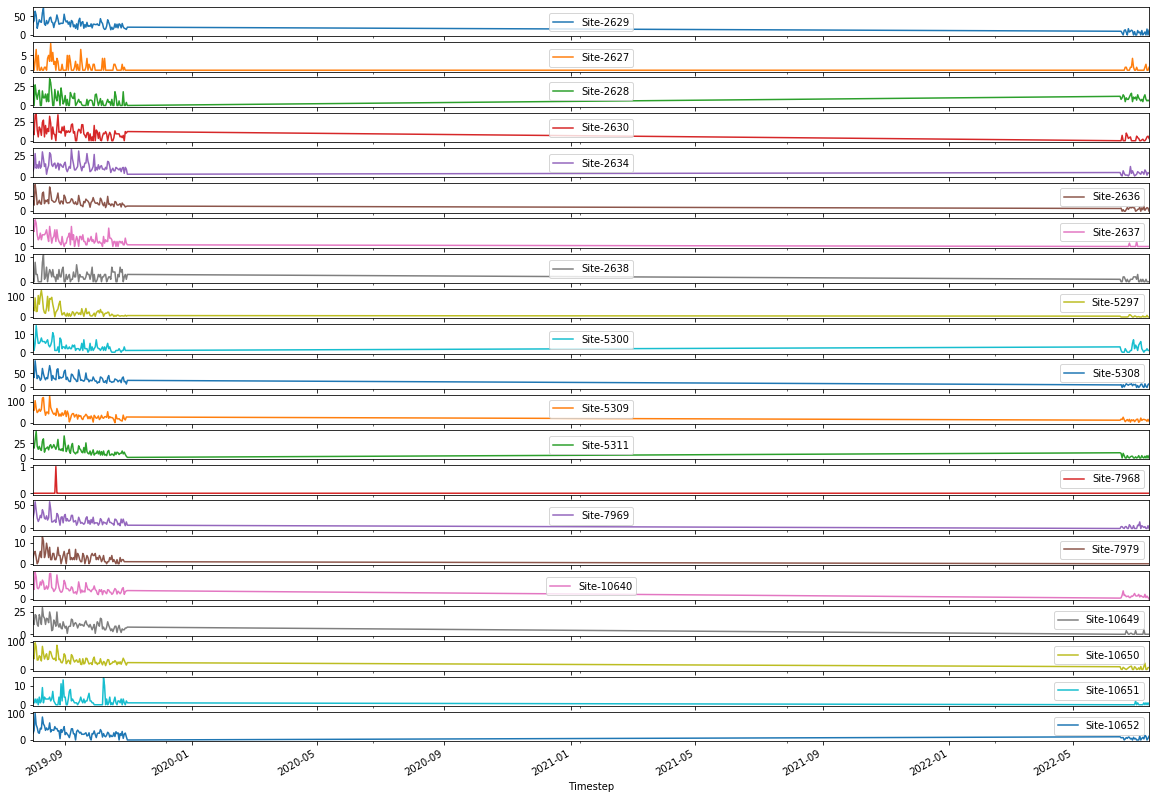

In [10]:
sites_meeting_data['Site-2629'].plot(figsize=(20, 15),subplots=True)                   
sites_meeting_data['Site-2629']

In [102]:
def multivariate_windowed_data(dataframe, window_size, target_size, batch_size,shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(dataframe)
    dataset = dataset.window(window_size+target_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+target_size))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda window: (window[:-target_size],window[-target_size:,0:1]))
    dataset = dataset.batch(batch_size).repeat()
    return dataset
    

In [103]:
TRAIN_SPLIT = 100
BATCH_SIZE = 100
window_size = 8
target_size = 5

In [104]:
# site_2629_meeting_values = site_2629_meeting_data.values
# site_2629_meeting_values.shape
sites_meeting_train_dataset={}
sites_meeting_validation_dataset={}
for site_key in sites_meeting_data:
    data=sites_meeting_data[site_key]
    sites_meeting_train_dataset[site_key]=multivariate_windowed_data(data.values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
    sites_meeting_validation_dataset[site_key]=multivariate_windowed_data(data.values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)


In [105]:
# site_2629_train_dataset = windowed_data(site_2629_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
# site_2629_validation_dataset = windowed_data(site_2629_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)

for x, y in sites_meeting_train_dataset['Site-2629'].take(1):
    print('x=',x.shape, 'y=',y.shape)
#     print('x=',x.numpy(), 'y=',y.numpy())

x= (88, 8, 21) y= (88, 5, 1)


In [127]:
tf.keras.backend.clear_session()
def train_model(train_dataset, validation_dataset, epochs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GRU(32,
                         dropout=0.2,
                         recurrent_dropout=0.2,
                         return_sequences=True,
                         input_shape=(None, 21)))
    model.add(tf.keras.layers.GRU(16, 
                         dropout=0.2,
                         recurrent_dropout=0.2,
#                            return_sequences=True,
                           activation='relu'))
#     model.add(tf.keras.layers.GRU(5, 
# #                          dropout=0.1,
# #                          recurrent_dropout=0.5,
#                            activation='relu'))
    model.add(tf.keras.layers.Dense(target_size,activation='relu'))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
    history = model.fit(train_dataset,
                        steps_per_epoch=50,
                                  epochs=100,
                                  validation_data=validation_dataset,
                       validation_steps=50)
    return model, history
    

# for site in PRED_SITES:
site=PRED_SITES[1]
site
model, history = train_model( sites_meeting_train_dataset[site], sites_meeting_validation_dataset[site], 500)
# plot_train_history(history, 'Training and validation loss for'+site) 

Train for 50 steps, validate for 50 steps
Epoch 1/100
50/50 [==============================] - 4s 71ms/step - loss: 37.2877 - val_loss: 11.9159
Epoch 2/100
50/50 [==============================] - 1s 16ms/step - loss: 20.2544 - val_loss: 11.5657
Epoch 3/100
50/50 [==============================] - 1s 17ms/step - loss: 17.6078 - val_loss: 10.9044
Epoch 4/100
50/50 [==============================] - 1s 17ms/step - loss: 16.9556 - val_loss: 10.6669
Epoch 5/100
50/50 [==============================] - 1s 16ms/step - loss: 16.4766 - val_loss: 9.7731
Epoch 6/100
50/50 [==============================] - 1s 16ms/step - loss: 15.9430 - val_loss: 9.1426
Epoch 7/100
50/50 [==============================] - 1s 17ms/step - loss: 15.6476 - val_loss: 8.4065
Epoch 8/100
50/50 [==============================] - 1s 16ms/step - loss: 15.3374 - val_loss: 8.4392
Epoch 9/100
50/50 [==============================] - 1s 16ms/step - loss: 15.1174 - val_loss: 8.1214
Epoch 10/100
50/50 [=========================

Epoch 81/100
50/50 [==============================] - 1s 16ms/step - loss: 10.0735 - val_loss: 8.9665
Epoch 82/100
50/50 [==============================] - 1s 16ms/step - loss: 10.0534 - val_loss: 9.2534
Epoch 83/100
50/50 [==============================] - 1s 16ms/step - loss: 10.0005 - val_loss: 9.2726
Epoch 84/100
50/50 [==============================] - 1s 16ms/step - loss: 9.8844 - val_loss: 9.8104
Epoch 85/100
50/50 [==============================] - 1s 17ms/step - loss: 9.8401 - val_loss: 10.6250
Epoch 86/100
50/50 [==============================] - 1s 16ms/step - loss: 9.8441 - val_loss: 10.6802
Epoch 87/100
50/50 [==============================] - 1s 16ms/step - loss: 9.7692 - val_loss: 10.7769
Epoch 88/100
50/50 [==============================] - 1s 17ms/step - loss: 9.7267 - val_loss: 10.5656
Epoch 89/100
50/50 [==============================] - 1s 16ms/step - loss: 9.7969 - val_loss: 10.9374
Epoch 90/100
50/50 [==============================] - 1s 16ms/step - loss: 9.8057 -

In [67]:
plot_train_history(history, 'Multi-Step Training and validation loss')

NameError: name 'history' is not defined

In [124]:
# for site in PRED_SITES:
plot_forecast_scene_2(model ,sites_meeting_data[site],site, window_size,target_size)
pred = p_day_forecast_scene_2(model,sites_meeting_data[site],site,window_size, target_size)
# print(pred)
pred['Value'].plot()


NameError: name 'plot_forecast_scene_2' is not defined

In [116]:

pred.to_csv( base_dir + r'/prediction/'+site+'_forcast_2.csv',index=False)

In [61]:
def p_day_forecast_scene_2(model, data, site, window_size, target_size):
    last_date=data.index[-1]
    after_p_day = datetime(2022, 7, 15)
    delta = after_p_day-last_date
    x = data.values[-window_size:]
    for time in range (0, 30 + delta.days,target_size):
        pred = model.predict(x[np.newaxis, time:time+window_size].astype(np.float32)) 
        pred = pred.reshape((target_size,1))
        pred=np.rint(pred)
        y = np.empty((target_size, x.shape[1]))
        y[:,0:1]=pred
        y[:,1:]=0
        x = np.concatenate([x, y], axis=0)
    
    index=pd.date_range(data.index[-window_size], periods=x.shape[0])
    x=pd.DataFrame(x[:,0],index=index,columns=['Value'])
    x.index.rename('Timestep',inplace=True)
    x = x[after_p_day:after_p_day+timedelta(30)]
    x['Scenario']='Scenario 2'
    x['Site'] = site
    x = x.reset_index()
    x=x[['Scenario','Site','Timestep','Value']]
    return x


# p_day_forecast_scene_2(model,sites_meeting_data['Site-2629'],'Site-2629',window_size, target_size)

In [69]:
def plot_forecast_scene_2(model, data, site, window_size,target_size):
    forecast = []
    values=data.values
    for time in range(0, len(values) - window_size,target_size):
        x=values[time:time + window_size][np.newaxis].astype(np.float32)
        pred = model.predict(x)
        pred = pred.reshape(target_size)
        forecast.append(pred)
    forecast = np.array(forecast).reshape(-1)
    res = pd.concat([data[window_size:].reset_index()[site], pd.DataFrame(forecast)], axis =1)
    res.plot()

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">
Predict Test Question 6
</p> 

In [ ]:
def f_day_forecast(model, data, site, window_size, target_size):
    last_date=data.index[-1]
    f_day = datetime(2022, 7, 14)
    start_day = f_day-timedelta(window_size)
    print(start_day)
    
    
    x = data.values[start_day:start_day+window_size]
    pred = model.predict(x[np.newaxis, time:time+window_size].astype(np.float32)) 
    pred = pred.reshape((target_size,1))
    pred=np.rint(pred) 
    print(pred)
    print(pred[0])
#     for time in range (0, 30 + delta.days,target_size):
#         pred = model.predict(x[np.newaxis, time:time+window_size].astype(np.float32)) 
#         pred = pred.reshape((target_size,1))
#         pred=np.rint(pred) 
#         x = np.concatenate([x, pred], axis=0)
    
#     index=pd.date_range(data.index[-window_size], periods=x.shape[0])
#     x=pd.DataFrame(x,index=index, columns=['Value'])
#     x.index.rename('Timestep',inplace=True)
#     x = x[p_day:p_day+timedelta(30)]
#     x['Scenario']='Scenario 1'
#     x['Site'] = site
#     x = x.reset_index()
#     x=x[['Scenario', 'Site', 'Timestep', 'Value']]
    return pred[0]
    